In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from math import *
import glob
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [253]:
# Адаптируем данные, создаем сводные таблицы опцион-индекс для каждого тикера
path = r'/content/drive/MyDrive/Андан Проект/Обработанные данные/'
names = glob.glob(path + '*.xlsx')
ticker_names = ('SPY', 'SPX', 'QQQ')

def merge_indexes_options(df_indexes, df_options, ticker):

    df_indexes.drop(columns=[f'high_{ticker}', f'low_{ticker}', f'close_{ticker}',
                             f'volume_{ticker}', f'log_return_{ticker}'],
                    inplace=True)
    df_options.drop(columns=['size', 'expire_date', 'ticker', 'buy_volume'],
                    inplace=True)
    df_indexes.rename(columns={f'open_{ticker}':'S',
                              f'std_log_return_{ticker}':'sigma'},
                      inplace=True)
    df_options.rename(columns={'transact_time': 'time', 'price': 'opt_price',
                               'days_before_expire_date':'T', 'strike_price':'X'},
                      inplace=True)
    df_options['time'] = df_options['time'].apply(lambda x: x.floor('min'))
    df = pd.merge_asof(df_options.sort_values('time'),
                       df_indexes.sort_values('time'),
                       on='time')
    df = df.drop(df[df['T'] == 0].index)
    return df

indexes_dict = {}
options_dict = {}
for name in names:
    t, ticker = name.replace(path, '').replace('.xlsx', '').split('_')
    df = pd.read_excel(name)
    if t == 'Index':
        indexes_dict[ticker] = df
    elif t == 'Options':
        options_dict[ticker] = df
df_dict = {}
for ticker in ticker_names:
    df_dict[ticker] = merge_indexes_options(indexes_dict[ticker],
                                            options_dict[ticker],
                                            ticker)

In [254]:
def black_scholse_price(row):
    r = 0.03
    year = 252
    d1 = (np.log(row['S'] / row['X']) + (r + 0.5 * row['sigma'] ** 2) * row['T'] / year) / (row['sigma'] * np.sqrt(row['T'] / year))
    d2 = d1 - row['sigma'] * np.sqrt(row['T'] / year)

    if row['call_put_flag'] == 'C':
        return round(row['S'] * sts.norm.cdf(d1) - row['X'] * np.exp(-r * row['T'] / year) * sts.norm.cdf(d2))
    else:
        return round(row['X'] * np.exp(-r * row['T'] / year) * sts.norm.cdf(-d2) - row['S'] * sts.norm.cdf(-d1))

In [255]:
for ticker in ticker_names:
    df_dict[ticker]['Black_Scholse_price'] = df_dict[ticker].apply(black_scholse_price, axis=1)

#  Проверка гипотез

---



### Гипотеза 1

Нам было интересно, насколько совершенно работает рынок. При допущении отсутстствия арбитража, цены кол и пут опционов должны совпадать с теоретическими ценами, рассчитанными по формуле Блэка-Шоуза. Проверим это с помощью анализа данных, методами математической статистики.

$H_0$: Цены на колл и пут опционы на рынке незначительно отличаются от теоретических цен, рассчитанных по формуле Блэка-Шоуза, допустимое отклонение от формулы 3$.

$H_A$: Цены колл и пут опционов на рынке значительно отличаются от теоретической цены по Блэк-Шоулзу.

Смотрим, есть ли выбросы в данных.

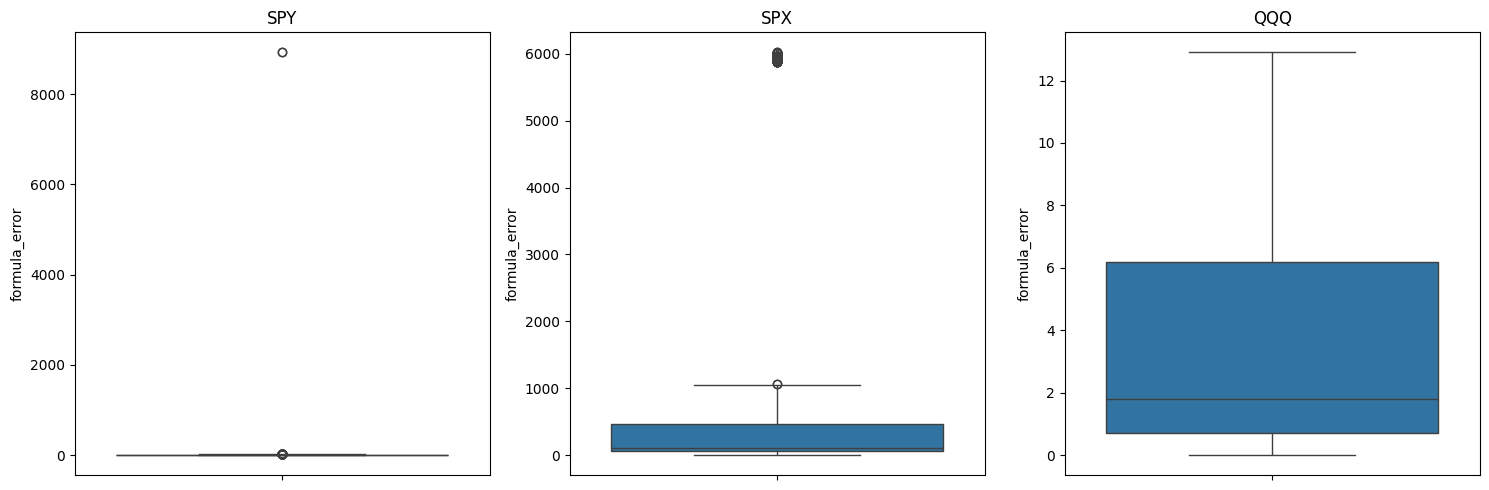

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ticker in enumerate(ticker_names):
    df = df_dict[ticker]
    df['formula_error'] = np.abs(df['opt_price'] - df['Black_Scholse_price'])
    sns.boxplot(df['formula_error'], ax=axes[i], label=ticker)
    axes[i].set_title(ticker)
    df_dict[ticker] = df
plt.tight_layout()

Мы приняли решение убрать выбросы, т.к. их не очень много и это скорее аномалии.
Также убираем строчки, в которых формула Блэка-Шоулза выдала значение 0, т.к. околонулевые цены опционов имеют очень маленькую ошибку на формуле, которая выдает для них строго 0. При этом очень низкие цены опционов - предполагаем, что это спекулятивная составляющая рынка. Построим новые диаграммы.

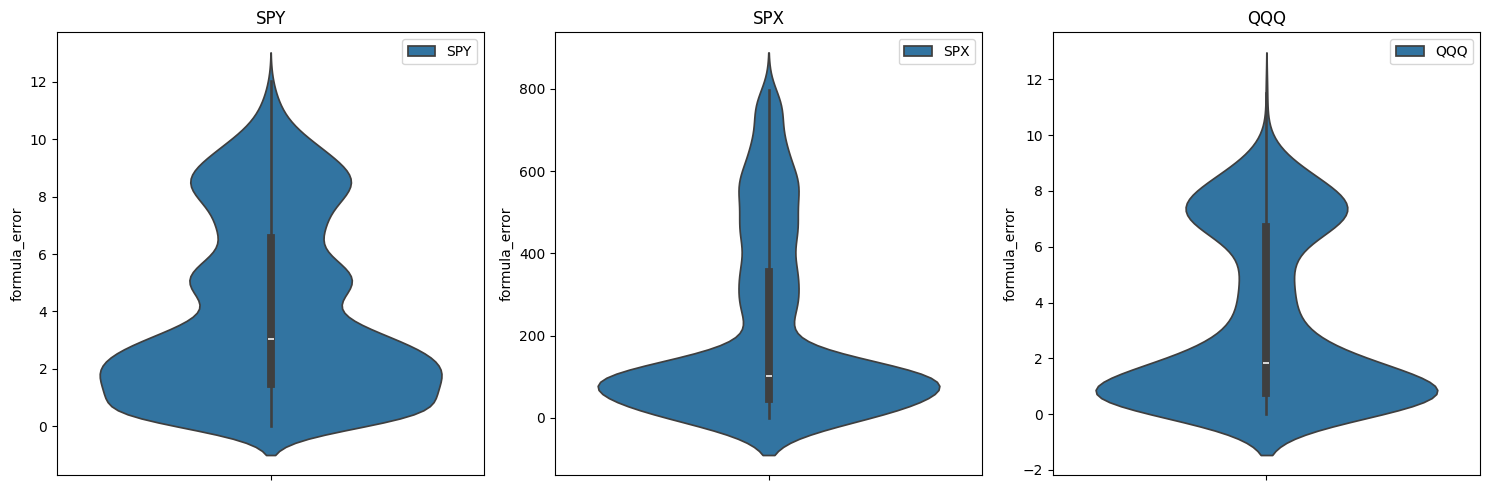

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ticker in enumerate(ticker_names):
    df = df_dict[ticker]
    q = 0.99
    #  у SPX очень большие выбросы, поэтому изменили для него кванитель
    if ticker == 'SPX':
        q = 0.9
    df = df.drop(df[df['Black_Scholse_price'] == 0].index)
    df = df.drop(df[df['formula_error'] > np.quantile(df['formula_error'],
                                                      q)].index)
    sns.violinplot(y=df['formula_error'], ax=axes[i], label=ticker)
    axes[i].set_title(ticker)
    df_dict[ticker] = df
plt.tight_layout()

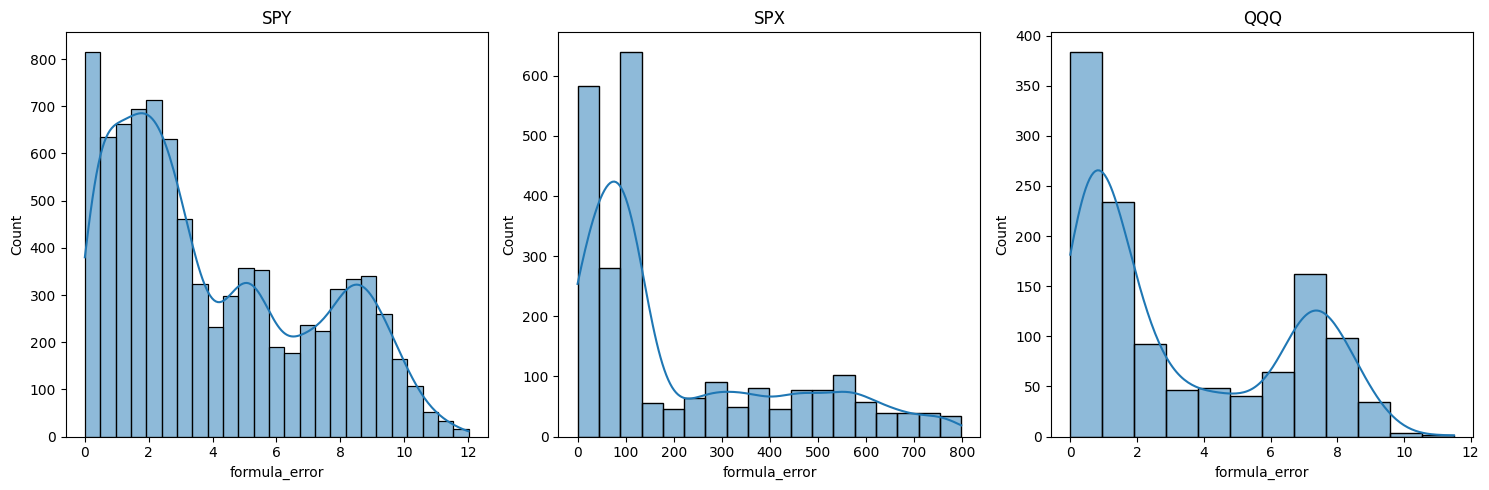

In [258]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ticker in enumerate(ticker_names):
    df = df_dict[ticker]
    sns.histplot(df['formula_error'], kde=True, ax=axes[i])
    axes[i].set_title(ticker)
    df_dict[ticker] = df
plt.tight_layout()

Заметим, что для индекса SPX ошибка формулы намного больше, чем на двух других индексах.

Построим доверительный интервал для среднего по показателю модуль ошибки формулы. Так как распределение модуля ошибок нельзя апроксимировать классической функцией распределения(выдно из предыдущих графиков), построим бутстрап.

In [259]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B_sample), replace=True)

    if B_sample == 1:
        sample = sample.T[0]
    return sample

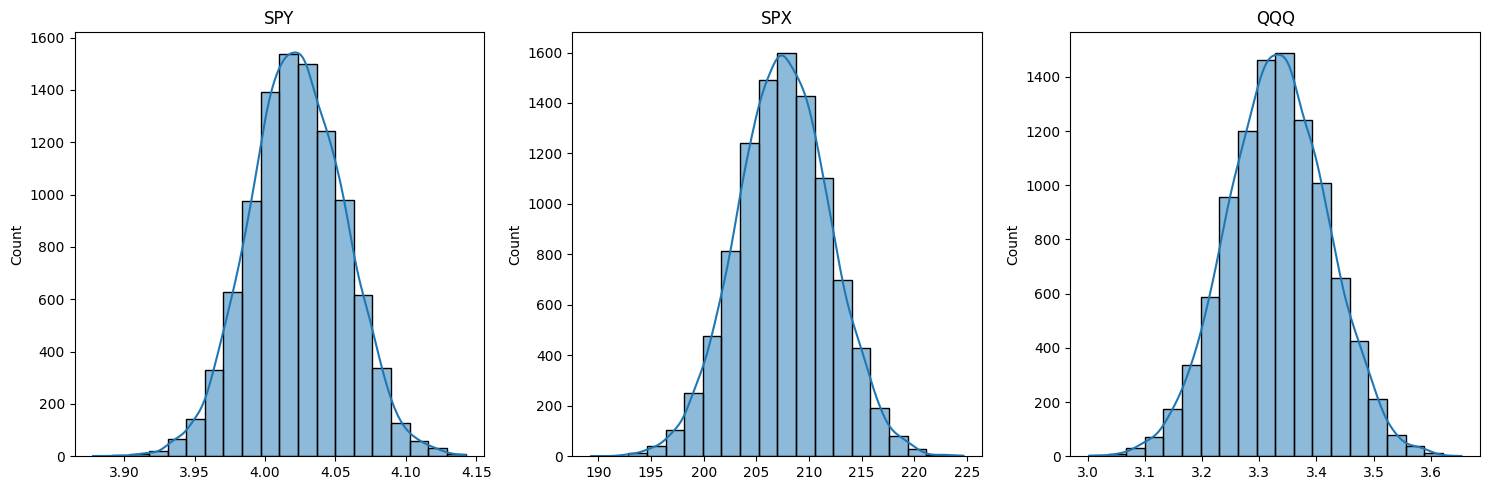

In [260]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ci = []
for i, ticker in enumerate(ticker_names):
    x = df_dict[ticker]['formula_error']
    x_boot = get_bootstrap_sample(x, B_sample=10**4)
    x_boot_m = np.mean(x_boot, axis=0)
    sns.histplot(x_boot_m, bins=20, kde=True, ax=axes[i], label=ticker)
    axes[i].set_title(ticker)
    ci.append((ticker, round(np.quantile(x_boot_m, 0.05), 3), round(np.quantile(x_boot_m, 0.95), 3)))
plt.tight_layout()

In [261]:
print(*['Доверительный интверал для {}: ({}; {})'.format(*ci[i]) for i in range(len(ticker))],
      sep='\n')

Доверительный интверал для SPY: (3.968; 4.078)
Доверительный интверал для SPX: (200.343; 214.987)
Доверительный интверал для QQQ: (3.188; 3.477)


Хотим обратить внимание на то, что не понимаем по какой причине такая большая средняя ошибка на индексе 'SPX'. Возможно, это связано со спекуляциями.

# Гипотеза 2

Интересно, как отличаются кол и пут опционы и ошибка формулы для них, есть ли существенное различие?

Проверим.

$H_0$: Ошибка формулы для кол и пут опционов существенно отличается.

$H_A$: Ошибки формулы одинаковы для кол и пут опционов.

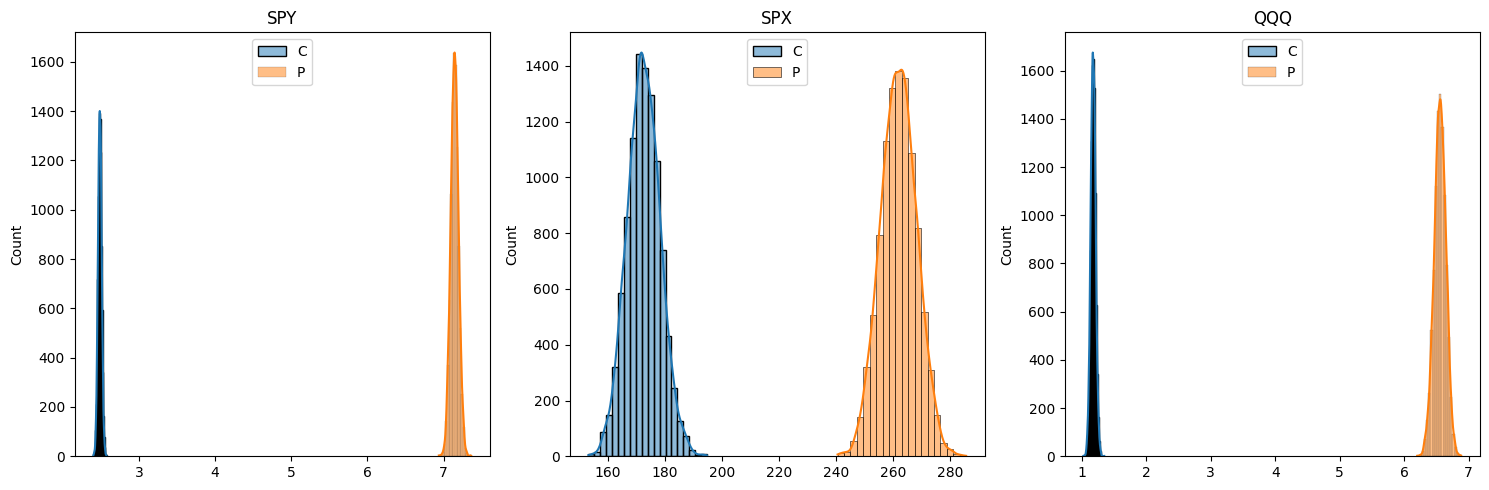

In [262]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ticker in enumerate(ticker_names):
    df = df_dict[ticker]
    x = df[(df['call_put_flag'] == 'C') & (df['Black_Scholse_price'] > 0.5)]['formula_error']
    y = df[(df['call_put_flag'] == 'P') & (df['Black_Scholse_price'] > 0.5)]['formula_error']
    x_boot = get_bootstrap_sample(x, B_sample=10**4)
    y_boot = get_bootstrap_sample(y, B_sample=10**4)
    x_boot_m = np.mean(x_boot, axis=0)
    y_boot_m = np.mean(y_boot, axis=0)
    sns.histplot(x_boot_m, bins=20, kde=True, ax=axes[i], label='C')
    sns.histplot(y_boot_m, bins=20, kde=True, ax=axes[i], label='P')
    axes[i].set_title(ticker)
    axes[i].legend(loc='upper center')
plt.tight_layout()

Мы получили крайне необычный результат. Исходя из приведенных выше графиков, средняя ошибка формулы Блэка-Шоулза для опционов типа "call" значительно меньше, чем для опционов типа "put". Это наблюдение открывает пространство для размышлений и интерпретаций. Например, если рассмотреть общий тренд рынка в анализируемый период, можно заметить, что он был преимущественно растущим. Возможно, это связано с тем, что игроки, делающие ставки на ограниченное повышение, стремятся более точно следовать математическим расчетам, в то время как игроки, играющие на понижение, допускают большие отклонения, так как вероятность такого исхода ниже. Кроме того, среди спекулянтов распространена практика покупки сомнительных опционов с надеждой использовать их в качестве рычага в случае небольшого падения рынка, чтобы затем продать их с прибылью.

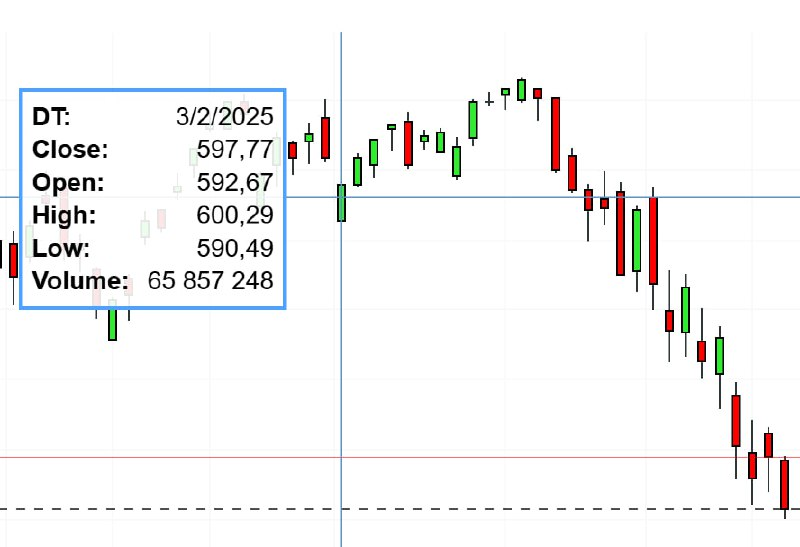